In [ ]:
from torch.utils.data import Dataset
import torch
import pandas as pd
import json
import os
from pathlib import Path
import torch
import torch.nn as nn

class CropYieldDataset(Dataset):
    def __init__(self, data_lake_dir="../data/data_lake_organized", crop_name="corn", transform=None):
        self.samples = [] # Stores (weather_tensor, yield_target, fips_id)
        self.transform = transform
        self.crop_name = crop_name.lower()
        self.fips_to_id = {} # Map FIPS string to integer ID
        self.id_to_fips = {} # Map integer ID back to FIPS string
        self._next_fips_id = 0

        fips_folders = [f for f in Path(data_lake_dir).iterdir() if f.is_dir()]

        for fips_folder in fips_folders:
            fips_code = fips_folder.name # The folder name is the FIPS code

            # Get or assign unique integer ID for this FIPS
            if fips_code not in self.fips_to_id:
                self.fips_to_id[fips_code] = self._next_fips_id
                self.id_to_fips[self._next_fips_id] = fips_code
                self._next_fips_id += 1

            fips_id = self.fips_to_id[fips_code]

            crop_json_path = fips_folder / f"{self.crop_name}.json"
            if not crop_json_path.exists():
                continue

            with open(crop_json_path, 'r') as f:
                yield_data = json.load(f)

            year_folders = [y for y in fips_folder.iterdir() if y.is_dir()]

            for year_folder in year_folders:
                year_str = year_folder.name # Year is a string from folder name
                weather_csv = year_folder / f"WeatherTimeSeries{year_str}.csv"

                # Ensure year_str exists in yield_data before processing weather
                if year_str not in yield_data:
                     # print(f"Warning: No yield data for year {year_str} in FIPS {fips_code}") # Optional warning
                     continue

                if not weather_csv.exists():
                    # print(f"Warning: Weather CSV missing for FIPS {fips_code}, year {year_str}") # Optional warning
                    continue

                df = pd.read_csv(weather_csv)

                # Only keep April–October (assuming your training data is always this range)
                df = df[(df['Month'] >= 4) & (df['Month'] <= 10)]

                # Drop non-weather columns
                # Be careful: Make sure 'Year', 'Month', 'Day' columns exist before dropping
                cols_to_drop = ['Year', 'Month', 'Day']
                existing_cols_to_drop = [col for col in cols_to_drop if col in df.columns]
                df = df.drop(columns=existing_cols_to_drop, errors='ignore')

                # Make sure it's float tensor
                weather_tensor = torch.tensor(df.values, dtype=torch.float32)

                # Target
                yield_target = torch.tensor(yield_data[year_str]['yield'], dtype=torch.float32)

                # Store sample as (weather_tensor, yield_target, fips_id)
                self.samples.append((weather_tensor, yield_target, fips_id))

        print(f"Loaded {len(self.samples)} samples for crop '{self.crop_name}'. Found {len(self.fips_to_id)} unique FIPS codes.")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        # Return (weather_tensor, yield_target, fips_id)
        x, y, fips = self.samples[idx]
        if self.transform:
            x = self.transform(x) # Apply transform only to weather data
        return x, y, fips

    def get_fips_mapping(self):
        return self.fips_to_id, self.id_to_fips

    def get_num_fips(self):
        return len(self.fips_to_id)
    
    
class MultiCropDataset(Dataset):
    def __init__(self, features_csv):
        df = pd.read_csv(features_csv)
        self.X = df.drop(columns=[
            'FIPS', 'Year',
            'Yield_corn', 'Yield_soybeans', 'Yield_cotton', 'Yield_winterwheat',
            'Production_corn', 'Production_soybeans', 'Production_cotton', 'Production_winterwheat'
        ]).fillna(0).values.astype('float32')

        self.y = df[[
            'Yield_corn', 'Yield_soybeans', 'Yield_cotton', 'Yield_winterwheat'
        ]].fillna(0).values.astype('float32')  # NaN yields set to 0 for now

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx]), torch.tensor(self.y[idx])

In [2]:
class LSTMTCNRegressor(nn.Module):
    def __init__(self, input_dim, num_fips, fips_embedding_dim=16, hidden_dim=64, lstm_layers=1, tcn_channels=[64, 32], dropout_rate=0.1):
        super(LSTMTCNRegressor, self).__init__()

        self.fips_embedding = nn.Embedding(num_fips, fips_embedding_dim)

        # Input to LSTM will be weather_features + fips_embedding_dim
        lstm_input_dim = input_dim + fips_embedding_dim

        self.lstm = nn.LSTM(lstm_input_dim, hidden_dim, num_layers=lstm_layers, batch_first=True, dropout=dropout_rate if lstm_layers > 1 else 0)

        # TCN part: using 1D Convolutions
        tcn_layers = []
        in_channels = hidden_dim
        for out_channels in tcn_channels:
             tcn_layers.append(nn.Conv1d(in_channels, out_channels, kernel_size=3, padding=1))
             tcn_layers.append(nn.ReLU())
             in_channels = out_channels

        self.tcn = nn.Sequential(*tcn_layers)

        # Adaptive pooling after TCN
        self.pooling = nn.AdaptiveAvgPool1d(1) # output shape: (batch, channels, 1)

        # Final fully connected layer
        self.fc = nn.Linear(tcn_channels[-1], 1) # Outputting 1 value for point estimate

        self.dropout_rate = dropout_rate # Store dropout rate

    def forward(self, x_weather, fips_ids):
        # x_weather shape: (batch, time_steps, weather_features)
        # fips_ids shape: (batch,)

        # Get county embeddings and unsqueeze for concatenation
        fips_emb = self.fips_embedding(fips_ids) # (batch, fips_embedding_dim)
        # Repeat embedding across the time dimension to match weather sequence length
        # (batch, 1, fips_embedding_dim) -> (batch, time_steps, fips_embedding_dim)
        fips_emb = fips_emb.unsqueeze(1).repeat(1, x_weather.size(1), 1)

        # Concatenate weather features and county embeddings
        x_combined = torch.cat([x_weather, fips_emb], dim=-1) # (batch, time_steps, weather_features + fips_embedding_dim)

        # Pass through LSTM
        # out shape: (batch, time_steps, hidden_dim)
        out, _ = self.lstm(x_combined)

        # Apply dropout to LSTM output if needed (LSTM layer handles this if num_layers > 1)
        # If dropout was applied internally by LSTM, we don't need another one here usually.
        # If lstm_layers == 1 and dropout_rate > 0, you might add nn.Dropout(self.dropout_rate)(out) here
        # But let's rely on LSTM's built-in dropout for simplicity if layers > 1

        # Permute for Conv1D
        out = out.permute(0, 2, 1)  # (batch, hidden_dim, time_steps)

        # Pass through TCN
        out = self.tcn(out) # (batch, tcn_channels[-1], time_steps_after_conv) - padding=1 keeps length

        # Apply pooling
        out = self.pooling(out)  # (batch, tcn_channels[-1], 1)

        # Squeeze the last dimension
        out = out.squeeze(-1)  # (batch, tcn_channels[-1])

        # Pass through final FC layer
        out = self.fc(out)  # (batch, 1)

        return out.squeeze(-1) # Output (batch,)

Multicrop LSTM TCN Regressor

In [23]:
class LSTMTCNMultiCropRegressor(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, lstm_layers=1, tcn_channels=[64, 32], output_dim=4):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=lstm_layers, batch_first=True)
        self.tcn = nn.Sequential(
            nn.Conv1d(hidden_dim, tcn_channels[0], kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(tcn_channels[0], tcn_channels[1], kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1)
        )
        self.fc = nn.Linear(tcn_channels[-1], output_dim)

    def forward(self, x):
        out, _ = self.lstm(x)  # (B, T, H)
        out = out.permute(0, 2, 1)  # (B, H, T)
        out = self.tcn(out)         # (B, C, 1)
        out = out.squeeze(-1)       # (B, C)
        return self.fc(out)         # (B, 4)

In [24]:
class MultiCropYieldDataset(Dataset):
    def __init__(self, features_csv, crops=['corn', 'soybeans', 'cotton', 'winterwheat']):
        self.df = pd.read_csv(features_csv)
        self.crops = crops
        self.features = self.df.drop(columns=[f"Yield_{c}" for c in crops] + [f"Production_{c}" for c in crops if f"Production_{c}" in self.df.columns])
        self.targets = self.df[[f"Yield_{c}" for c in crops]]
        self.features.fillna(0, inplace=True)
        self.targets = self.targets.fillna(-1)  # use -1 or mask later

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        x = torch.tensor(self.features.iloc[idx].values, dtype=torch.float32)
        y = torch.tensor(self.targets.iloc[idx].values, dtype=torch.float32)
        return x, y

Preprocess weather data:

In [25]:
def preprocess_raw_weather(weather_df):
    df = weather_df.copy()
    df = df[(df['Month'] >= 4) & (df['Month'] <= 10)]
    x = range(len(df))

    features = {}

    for col in [
        'Avg Temperature (K)', 'Max Temperature (K)', 'Min Temperature (K)',
        'Precipitation (kg m**-2)', 'Relative Humidity (%)',
        'Wind Gust (m s**-1)', 'Wind Speed (m s**-1)',
        'U Component of Wind (m s**-1)', 'V Component of Wind (m s**-1)',
        'Downward Shortwave Radiation Flux (W m**-2)',
        'Vapor Pressure Deficit (kPa)'
    ]:
        if col in df.columns:
            features[f"{col} Mean"] = df[col].mean()
            features[f"{col} Std"] = df[col].std()
            features[f"{col} Max"] = df[col].max()
            features[f"{col} Min"] = df[col].min()

    # Extremes
    features['Hot Days >35C'] = (df['Max Temperature (K)'] > 308.15).sum()
    features['Cold Days <5C'] = (df['Min Temperature (K)'] < 278.15).sum()
    features['Heavy Rain Days >10mm'] = (df['Precipitation (kg m**-2)'] > 10).sum()
    features['Dry Days <1mm'] = (df['Precipitation (kg m**-2)'] < 1).sum()

    # Trends
    if len(df) > 1:
        features['Avg Temp Trend (slope)'] = linregress(x, df['Avg Temperature (K)'])[0]
        features['Precipitation Trend (slope)'] = linregress(x, df['Precipitation (kg m**-2)'])[0]
    else:
        features['Avg Temp Trend (slope)'] = 0
        features['Precipitation Trend (slope)'] = 0

    return torch.tensor(list(features.values()), dtype=torch.float32).unsqueeze(0)

In [8]:
# Collate function for DataLoader
def collate_fn(batch):
    # batch is a list of (weather_tensor, yield_target, fips_id) tuples
    xs = [item[0] for item in batch] # weather_tensor
    ys = [item[1] for item in batch] # yield_target
    fips_ids = [torch.tensor(item[2], dtype=torch.long) for item in batch] #

    # Pad weather sequences
    xs_padded = nn.utils.rnn.pad_sequence(xs, batch_first=True, padding_value=0) # Choose a padding_value (0 is common for weather)

    # Stack targets and fips_ids
    ys_stacked = torch.stack(ys)
    fips_ids_stacked = torch.stack(fips_ids)

    return xs_padded, ys_stacked, fips_ids_stacked

In [13]:
from torch.utils.data import DataLoader, random_split
import torch.optim as optim
import tqdm
from sklearn.metrics import mean_squared_error, mean_absolute_error

def get_dataloaders(dataset, train_ratio=0.8, batch_size=32):
    """
    Splits the dataset into training and validation sets and returns DataLoaders.
    Includes the custom collate_fn.
    """
    total_len = len(dataset)
    train_len = int(total_len * train_ratio)
    val_len = total_len - train_len

    # Ensure split is valid
    if train_len == 0 or val_len == 0:
        raise ValueError("Dataset too small for train/validation split.")

    train_dataset, val_dataset = random_split(dataset, [train_len, val_len])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

    return train_loader, val_loader

def train_model(model, train_loader, val_loader, num_epochs=30, lr=1e-3):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    best_val_loss = float('inf')

    for epoch in tqdm.tqdm(range(num_epochs), desc="Training Progress"):
        model.train()
        epoch_loss = 0
        for x_batch, y_batch, fips_batch in train_loader:
            x_batch, y_batch, fips_batch = x_batch.to(device), y_batch.to(device), fips_batch.to(device)

            optimizer.zero_grad()
            y_pred = model(x_batch, fips_batch) # Pass FIPS IDs
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        # Validation loss
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for x_val, y_val, fips_val in val_loader:
                x_val, y_val, fips_val = x_val.to(device), y_val.to(device), fips_val.to(device)
                y_pred = model(x_val, fips_val) # Pass FIPS IDs
                val_loss += criterion(y_pred, y_val).item()

        avg_train_loss = epoch_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)

        """ tqdm.tqdm.write(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_train_loss} - Val Loss: {avg_val_loss}")
        tqdm.tqdm.set_description(f"Training Progress (Epoch {epoch+1} Val Loss: {avg_val_loss})") """

        # Simple early stopping or saving best model based on validation loss
        if avg_val_loss < best_val_loss:
             best_val_loss = avg_val_loss
             # You might want to save the model state here: torch.save(model.state_dict(), 'best_model.pth')

    return model # Return the trained model

def evaluate_model(model, val_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval() # Set model to evaluation mode (dropout is off by default)
    y_true = []
    y_pred = []

    with torch.no_grad():
        for x_val, y_val, fips_val in val_loader: # Unpack FIPS IDs
            x_val, y_val, fips_val = x_val.to(device), y_val.to(device), fips_val.to(device)
            outputs = model(x_val, fips_val) # Pass FIPS IDs
            y_true.extend(y_val.cpu().numpy())
            y_pred.extend(outputs.cpu().numpy())

    rmse = mean_squared_error(y_true, y_pred, squared=False)
    mae = mean_absolute_error(y_true, y_pred)

    print(f"Final Validation RMSE: {rmse:.4f}")
    print(f" Final Validation MAE: {mae:.4f}")

    return rmse, mae

In [15]:
# Instantiate the dataset
dataset = CropYieldDataset(crop_name="corn")

# Get county mapping and number of unique counties
fips_to_id, id_to_fips = dataset.get_fips_mapping()
num_fips = dataset.get_num_fips()

# Get dataloaders
# Add try-except in case the dataset is too small after filtering
try:
    train_loader, val_loader = get_dataloaders(dataset, batch_size=32)
except ValueError as e:
    print(f"Error creating dataloaders: {e}")
    print("Dataset may be too small for split after filtering.")
    # Handle this case, maybe exit or use a different strategy

# Detect input_dim (number of weather features)
# Ensure the loader has data before accessing shape
input_dim = -1
if len(dataset) > 0:
    sample_weather, _, _ = dataset[0]
    input_dim = sample_weather.shape[-1]
else:
    print("Dataset is empty. Cannot determine input_dim.")
    # Handle empty dataset case

if input_dim != -1:
    # Instantiate the model with num_fips and embedding dim
    # You can add fips_embedding_dim to your hyperparameters if tuning
    model = LSTMTCNRegressor(input_dim=input_dim, num_fips=num_fips, fips_embedding_dim=16) # Choose an embedding dim

    # Train the model
    # Pass loaders, num_epochs, lr
    trained_model = train_model(model, train_loader, val_loader, num_epochs=2)
    
    # Evaluate
    evaluate_model(trained_model, val_loader)

    # Hyperparameter tuning (needs update to pass num_fips and embedding_dim)
    # The random search function would need modification similar to train_model
    # to pass fips_ids and instantiate the model with num_fips and fips_embedding_dim
    # For brevity, I won't rewrite the whole tuning function here, but the principle is the same.
    # You'd need to add num_fips and fips_embedding_dim to the model instantiation inside the loop.
    # Example inside the loop:
    # model = LSTMTCNRegressor(input_dim=input_dim, num_fips=num_fips, fips_embedding_dim=random.choice([8, 16, 32]), ...)
    # trained_model = train_model(model, train_loader, val_loader, num_epochs=num_epochs, lr=lr)

Loaded 552 samples for crop 'corn'. Found 99 unique FIPS codes.


Training Progress: 100%|██████████| 2/2 [00:01<00:00,  1.08it/s]

Final Validation RMSE: 178.5846
 Final Validation MAE: 177.4739



c:\Users\saadh\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [26]:
def infer_yields(model, raw_weather_df, feature_names):
    x_input = preprocess_raw_weather(raw_weather_df)
    x_input = x_input[:, :len(feature_names)]  # match training feature order if needed
    model.eval()
    with torch.no_grad():
        prediction = model(x_input)
        return prediction.squeeze().tolist()


Inference for corn in FIPS 19109, Year 2022, up to 2022-06-15
Mean predicted yield: 17.18
Std Dev of predicted yield: 0.00


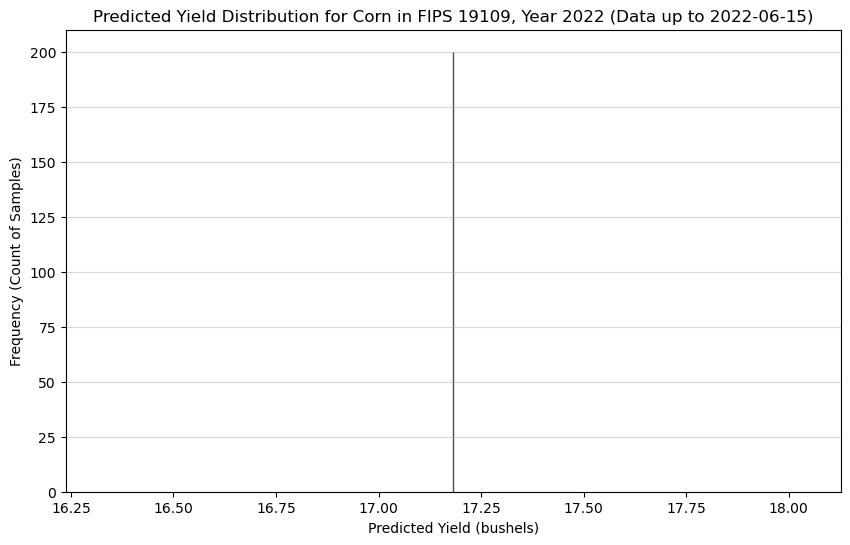


Histogram Data:
  Yield range: 17.18 - 17.18, Count: 0
  Yield range: 17.18 - 17.18, Count: 0
  Yield range: 17.18 - 17.18, Count: 0
  Yield range: 17.18 - 17.18, Count: 0
  Yield range: 17.18 - 17.18, Count: 0
  Yield range: 17.18 - 17.18, Count: 0
  Yield range: 17.18 - 17.18, Count: 0
  Yield range: 17.18 - 17.18, Count: 0
  Yield range: 17.18 - 17.18, Count: 0
  Yield range: 17.18 - 17.18, Count: 0
  Yield range: 17.18 - 17.18, Count: 0
  Yield range: 17.18 - 17.18, Count: 0
  Yield range: 17.18 - 17.18, Count: 0
  Yield range: 17.18 - 17.18, Count: 0
  Yield range: 17.18 - 17.18, Count: 0
  Yield range: 17.18 - 17.18, Count: 0
  Yield range: 17.18 - 17.18, Count: 0
  Yield range: 17.18 - 17.18, Count: 0
  Yield range: 17.18 - 17.18, Count: 200


In [22]:
import pandas as pd
import torch
import torch.nn as nn
from pathlib import Path
import json
import numpy as np
import matplotlib.pyplot as plt # Optional: for visualization


def predict_distribution(
    model,
    data_lake_dir,
    year,
    county_fips,
    crop_name,
    inference_date, # Example: '2023-05-15'
    fips_to_id_mapping,
    num_samples=30, # Number of runs for dropout sampling
    device=None
):
    """
    Predicts a yield distribution for a specific year, county, crop, and date
    using a trained model with dropout enabled at inference.

    Args:
        model (torch.nn.Module): The trained model.
        data_lake_dir (str): Path to the data lake root.
        year (int or str): The year for prediction.
        county_fips (str): The FIPS code for the county.
        crop_name (str): The name of the crop.
        inference_date (str): The date up to which weather data is available (YYYY-MM-DD).
        fips_to_id_mapping (dict): Dictionary mapping FIPS codes (str) to integer IDs.
        num_samples (int): Number of forward passes with dropout to sample the distribution.
        device (torch.device, optional): The device to use for inference. Defaults to cpu/cuda.

    Returns:
        tuple: (predicted_yields_samples, bins, hist_counts)
               predicted_yields_samples (list): List of individual predicted yields.
               bins (numpy.ndarray): Histogram bin edges.
               hist_counts (numpy.ndarray): Histogram counts per bin.
    """
    year_str = str(year)
    crop_name_lower = crop_name.lower()
    device = device if device else torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # --- 1. Load Partial Weather Data ---
    fips_folder = Path(data_lake_dir) / county_fips
    year_folder = fips_folder / year_str
    weather_csv = year_folder / f"WeatherTimeSeries{year_str}.csv"

    if not weather_csv.exists():
        print(f"Error: Weather CSV not found for FIPS {county_fips}, year {year_str}")
        return None, None, None

    df_weather = pd.read_csv(weather_csv)

    # Filter weather data up to the inference date
    try:
        inference_date_dt = pd.to_datetime(inference_date)
        df_weather['Date'] = pd.to_datetime(df_weather[['Year', 'Month', 'Day']])
        df_partial_weather = df_weather[df_weather['Date'] <= inference_date_dt].copy()
        # Drop the added 'Date' column and other non-weather columns
        cols_to_drop = ['Year', 'Month', 'Day', 'Date']
        existing_cols_to_drop = [col for col in cols_to_drop if col in df_partial_weather.columns]
        df_partial_weather = df_partial_weather.drop(columns=existing_cols_to_drop, errors='ignore')
    except Exception as e:
        print(f"Error processing dates: {e}")
        return None, None, None

    if df_partial_weather.empty:
        print(f"Error: No weather data found up to {inference_date} for FIPS {county_fips}, year {year_str}")
        return None, None, None

    # Convert to tensor
    weather_tensor = torch.tensor(df_partial_weather.values, dtype=torch.float32).unsqueeze(0).to(device) # Add batch dimension (1, T, features)

    # --- 2. Get County ID ---
    if county_fips not in fips_to_id_mapping:
        print(f"Error: County FIPS {county_fips} not found in the training mapping.")
        print("Model was not trained on this county.")
        # Option: Fallback to a default county embedding, or raise error
        return None, None, None

    fips_id = fips_to_id_mapping[county_fips]
    fips_tensor = torch.tensor([fips_id], dtype=torch.long).to(device) # (1,) tensor

    # --- 3. Run Model Multiple Times with Dropout ---
    model.eval() # Start in eval mode
    # Temporarily enable dropout for inference
    def enable_dropout(m):
        if type(m) == nn.Dropout:
            m.train()
        if type(m) == nn.LSTM: # LSTMs with dropout need .train() to apply dropout
             m.train() # Use .train() to enable dropout in LSTM/GRU
             # Need to restore state later
             # A safer way is to manually set dropout probability during inference
             # Let's stick to m.train() for simplicity first, but be aware
             # A more robust way involves a custom forward pass or modifying the module.
             # For LSTMs, .train() is the standard way to enable recurrent dropout.

    model.apply(enable_dropout) # Apply enable_dropout function recursively to all submodules

    predicted_yields = []
    with torch.no_grad(): # Disable gradient calculation for inference
        for _ in range(num_samples):
            # Pass weather and fips tensor (batch size 1)
            prediction = model(weather_tensor, fips_tensor)
            predicted_yields.append(prediction.item()) # Get the scalar prediction

    # Revert model back to standard eval mode (dropout off)
    model.eval()

    # --- 4. Generate Histogram Data ---
    # Determine bins (e.g., based on min/max predictions, or historical range if available)
    # For a simple approach, use the min/max of the sampled predictions
    min_yield = min(predicted_yields)
    max_yield = max(predicted_yields)
    # Create bins - e.g., 20 bins between min and max
    bins = np.linspace(min_yield, max_yield, 20) # Adjust number of bins as needed

    hist_counts, bin_edges = np.histogram(predicted_yields, bins=bins, density=False) # Use density=False for counts

    # You can normalize counts to get probabilities if needed: hist_probabilities = hist_counts / num_samples

    print(f"\nInference for {crop_name} in FIPS {county_fips}, Year {year}, up to {inference_date}")
    print(f"Mean predicted yield: {np.mean(predicted_yields):.2f}")
    print(f"Std Dev of predicted yield: {np.std(predicted_yields):.2f}")

    return predicted_yields, bin_edges, hist_counts

# --- How to use the inference function ---
# Assume 'trained_model' and 'fips_to_id' mapping are available after training

# Example Usage:
data_lake_root = "../data/data_lake_organized" # Set your data root path
target_year = 2022 # The year you want to predict for
target_county_fips = "19109" # Example FIPS (Cook County, IL - likely not a corn county, use a real one)
target_crop = "corn"
current_date = "2022-06-15" # Date up to which weather is available

# Make sure you have the fips_to_id mapping from the dataset object used for training
fips_to_id_mapping_from_training = dataset.get_fips_mapping()[0]


predicted_yields_samples, bins, hist_counts = predict_distribution(
    trained_model,
    data_lake_root,
    target_year,
    target_county_fips,
    target_crop,
    current_date,
    fips_to_id_mapping_from_training, # Pass the mapping
    num_samples=200, # More samples for better histogram
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
)

if predicted_yields_samples is not None:
    # You can plot the histogram
    plt.figure(figsize=(10, 6))
    plt.bar(bins[:-1], hist_counts, width=np.diff(bins), edgecolor='black', alpha=0.7)
    plt.xlabel("Predicted Yield (bushels)")
    plt.ylabel("Frequency (Count of Samples)")
    plt.title(f"Predicted Yield Distribution for {target_crop.capitalize()} in FIPS {target_county_fips}, Year {target_year} (Data up to {current_date})")
    plt.grid(axis='y', alpha=0.5)
    plt.show()

    # Or print histogram data
    print("\nHistogram Data:")
    for i in range(len(hist_counts)):
        print(f"  Yield range: {bins[i]:.2f} - {bins[i+1]:.2f}, Count: {hist_counts[i]}")